In [1]:
# Data manipulation
from os import path
import numpy as np
import pandas as pd
from itertools import groupby
import os
import csv
import math

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.colors import ListedColormap
import seaborn as sns

# Images manipulation
from skimage import img_as_float, img_as_ubyte, exposure, feature, morphology, measure, segmentation, transform, color
from skimage.restoration import denoise_nl_means, unsupervised_wiener, denoise_tv_bregman, denoise_bilateral
from skimage.util import compare_images, invert
from skimage.filters import threshold_multiotsu, difference_of_gaussians
#from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.registration import phase_cross_correlation
from skimage.io import imread
from scipy import stats, misc, ndimage
import cv2
import pyclesperanto_prototype as cle

# Network analysis
#import porespy as ps
#import openpnm as op
#import pytrax as pt

# Custom Color map with black as first color
cmap = plt.cm.get_cmap('terrain', 256)
newcolors = cmap(np.random.randint(256, size=100))
dark = np.array([0/256, 0/256, 0/256, 1])
newcolors[:1, :] = dark
custom_cmap = ListedColormap(newcolors)

matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
# Parameters 

# Reading the input file

# Image path and name
Inputs = pd.read_excel (r'Inputs_powder_PSD.xlsx')

folder_name = (Inputs["Parameters' value"][1])
print("Results path = ", folder_name)

file_name = str(Inputs["Parameters' value"][2])
print("File name = ", file_name)

path_original = folder_name + "\\" + file_name

# Scaledar detection
backgound_clr = str(Inputs["Parameters' value"][4]) # This stands for the color of the background - possible values: "b" for black, "w" for white, and "g" for grey
print("Background color = ", backgound_clr)

scalebar_clr = str(Inputs["Parameters' value"][5]) # This stands for the color of the scalebar - possible values: "b" for black, "w" for white, and "g" for grey
print("Scalebar color = ", scalebar_clr)

scalebar_lenght = float(Inputs["Parameters' value"][6]) # Scalebar size in um
print("Scalebar lenght (um) = ", scalebar_lenght)

# Voronoi-based istance segmentation
sigma_voronoi_center = (Inputs["Parameters' value"][8]) # Gaussian filter sigma (higher than sigma_dividing) to find the center of the voronois
try:
    sigma_voronoi_center = int(sigma_voronoi_center)
except:
    sigma_voronoi_center = 6
print("Gaussian for Voronois' center = ", sigma_voronoi_center)

sigma_dividing = (Inputs["Parameters' value"][9]) # Gaussian filter sigma (higher than sigma_dividing) to find the center of the voronois
try:
    sigma_dividing = int(sigma_dividing)
except:
    sigma_dividing = 1
print("Gaussian for Voronois' separation = ", sigma_dividing)

border_0 = str(Inputs["Parameters' value"][10]) # If removing (True) or not (False) particles touching the borders (advised: True)
if border_0 == "No":
    border = False
else:
    border = True
print("Removing particles on borders = ", border)

# Mateials density 
density_g_cm3 = (Inputs["Parameters' value"][12]) # Powder density in g/cm3 - to estimate the specific area distribution
try:
    density_g_cm3 = float(density_g_cm3)
except:
    density_g_cm3 = 0
print("Powder density [g cm-3] = ", density_g_cm3)

Results path =  C:\Users\teolo\Documents\Teo\Codes\New\SEM-segmentation and particle reconition\Final_2023_01\Kilian - powders PSD\example images
File name =  scLNO_01_Bing_01.tif
Background color =  w
Scalebar color =  b
Scalebar lenght (um) =  10.0
Gaussian for Voronois' center =  4
Gaussian for Voronois' separation =  2
Removing particles on borders =  True
Powder density [g cm-3] =  2.1


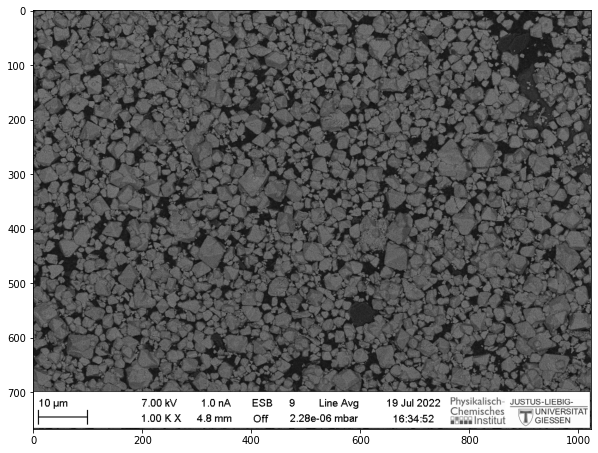

In [3]:
# Recover image and create result directories

img = img_as_ubyte(imread((path_original), as_gray=True))
plt.imshow(img, cmap='gray')

directory_res = folder_name + "\\" + "Results_" + file_name 
directory_checks = directory_res + "\\" + "Checks"

try: 
    os.makedirs(directory_res)
except:
    pass

try: 
    os.makedirs(directory_checks)
except:
    pass

In [4]:
def scalebar_detection(img, color_bkg=backgound_clr, color_bar=scalebar_clr, fib='False'):

    if color_bkg == 'b':
        thres = 0
    elif color_bkg == 'w':
        thres = 255
    elif color_bkg == 'g':
        thres = 96
    
    # Threshold values for the scalebar 
    if color_bar == 'w':
        thres_bar = 200
    elif color_bar == 'b':
        thres_bar = 20
    
    if fib:
        tick_l = 35
    else:
        tick_l = 25

    # Check the mode-color for each line, this detects at wich pixel the HUD is reached
    for line in range(len(img)):
        mode = stats.mode(img[line])
        if line >= 1:
            if int(mode[0]) == thres:
                boundary_h = line
                break
    
    # Separates the HUD from the rest of the image
    ime = img[boundary_h: , : ]

    # Vertical bar detection, for each line the number of contigous pixel
    # of the specified color are counted. This assumes that only the scalebar
    # is characterized by 'long' vertical lines of the given color
    boundary_v = []
    for i in range(1,ime.shape[1]-4):
        if color_bar == 'w':
            for key, group in groupby(ime[:,i]>thres_bar):
                if key:
                    a_list = np.array(list(group))
                    if len(a_list)> tick_l and a_list.all():
                        if (i-1) not in boundary_v:
                            boundary_v.append(i)
                    if len(boundary_v) >= 2:
                        break
        elif color_bar == 'b':
            for key, group in groupby(ime[:,i]<thres_bar):
                if key:
                    a_list = np.array(list(group))
                    if len(a_list)> tick_l and a_list.all():
                        if (i-1) not in boundary_v:
                            boundary_v.append(i)
                    if len(boundary_v) >= 2:
                        break
    return boundary_h, boundary_v

Text(0.5, 1.0, 'Scalebar of 10.0 µm: \n1.111e+02 nm/pixel')

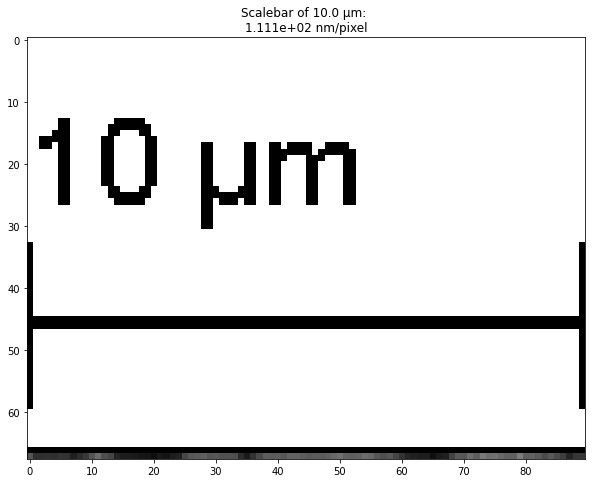

In [5]:
# Identify scalebar pixel lenght and calculate resolution
boundary_h, boundary_v = scalebar_detection(img, color_bkg='w', color_bar='b', fib=False) # color_bkg and color_bar to be indicated as beginner users parameters
ime = img[boundary_h: , (boundary_v[0]+1):(boundary_v[1]+1)]

# Calculates the pixel lengh in nm
pixel_lenght = 1000*scalebar_lenght/(boundary_v[1]-boundary_v[0])

# Plotting Jargon
plt.imshow(ime, cmap='gray')
plt.title('Scalebar of {} µm: \n{:.3e} nm/pixel'.format(scalebar_lenght, pixel_lenght ))
#print(pixel_lenght)

C:\Users\teolo\AppData\Local\Temp\ipykernel_5824\4211956498.py:4: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


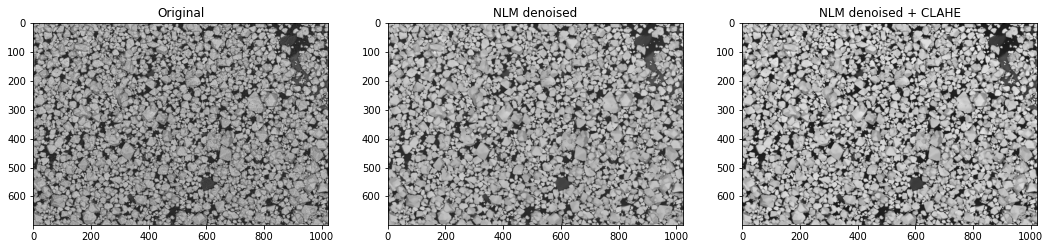

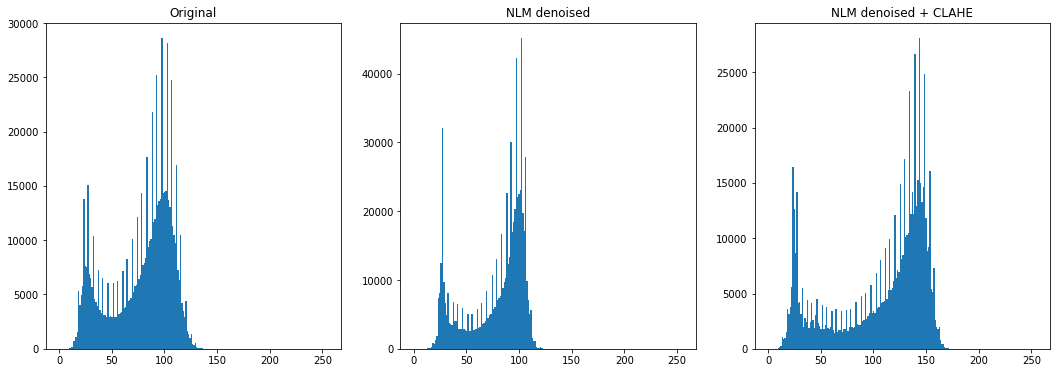

In [6]:
# Denoising of the original image
original_img = img[:boundary_h-1,:]
#plt.imshow(original_img, cmap="gray")
NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)
NLM_denoised = img_as_ubyte(NLM_denoised)

clip_lim = 1 # Parameter for expert users
grid_clahe = 8 # Parameter for expert users
clahe = cv2.createCLAHE(clipLimit=clip_lim, tileGridSize=(grid_clahe,grid_clahe)) # cliplimit and titleGridSize as expert user parameters -1,2 for cliplimit seems good for my case, but typically values seems to be 3,4
equalised_img = clahe.apply(NLM_denoised)
#equalised_img = img_as_ubyte(exposure.equalize_adapthist(NLM_denoised, kernel_size = 600, clip_limit=0.007))
#equalised_img = img_as_ubyte(equalised_img)

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(original_img, cmap="gray")
ax1.title.set_text("Original")
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(NLM_denoised, cmap="gray")
ax1.title.set_text("NLM denoised")
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(equalised_img, cmap="gray")
ax1.title.set_text("NLM denoised + CLAHE")
path_save = directory_checks + "\\" + "Denoise comparison.png"
plt.savefig(path_save, dpi=600)

# Checking histograms
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax1.hist(original_img.flat, bins=200, range=(0,255))
ax1.title.set_text("Original")
ax1 = fig.add_subplot(1,3,2)
ax1.hist(NLM_denoised.flat, bins=200, range=(0,255))
ax1.title.set_text("NLM denoised")
ax1 = fig.add_subplot(1,3,3)
ax1.hist(equalised_img.flat, bins=200, range=(0,255))
ax1.title.set_text("NLM denoised + CLAHE")
path_save = directory_checks + "\\" + "Denoise comparison - histograms.png"
plt.savefig(path_save, dpi=600)

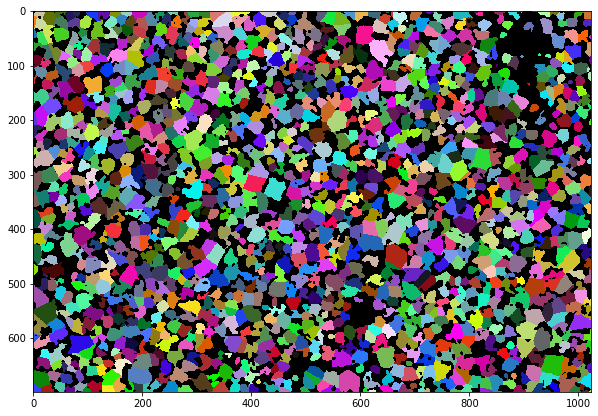

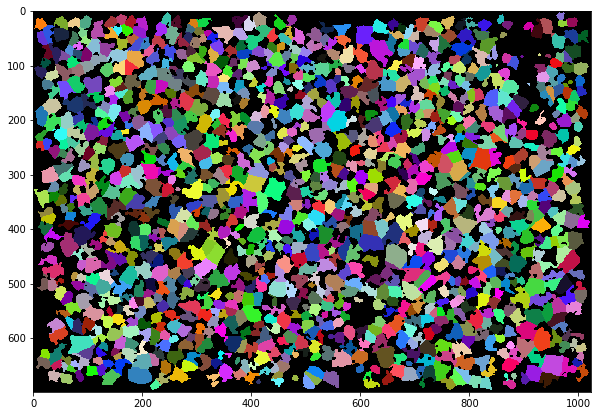

Total objects detected:  1202.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


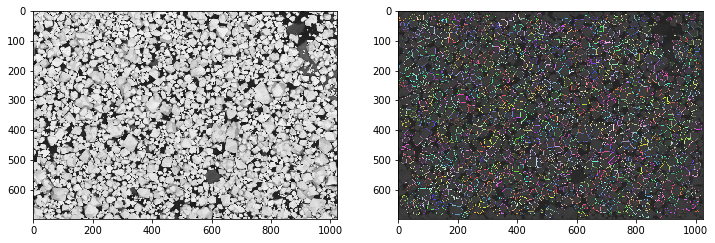

In [7]:
# Pyclesperanto-based instance (particle) segmentation
segmented_cle = cle.voronoi_otsu_labeling(equalised_img, spot_sigma=sigma_voronoi_center, outline_sigma=sigma_dividing) #First Gaussian filter sigma (higher) to find the center of the voronois, and second sigma (smaller) for dividing (like watershed) the different instance/object
# Higher the first sigma less particles/particles splitting find, and vice versa
#fig = plt.subplots(1, 2, figsize=(9,9))
cle.imshow(segmented_cle, labels=True)

#Remove edge touching objects
if border == True: 
    segmented_excl_edges = cle.exclude_labels_on_edges(segmented_cle)
if border == False:
    segmented_excl_edges = segmented_cle

cle.imshow(segmented_excl_edges, labels=True)

    
#path_save = directory_res + "\\" + "Recognized particles - Voronoi.png"
#plt.savefig(path_save, dpi=600)

# Number of objects segmented?
#This will be the maximum label assigned to an object 9as each object is assigned unique label value)
num_objects = cle.maximum_of_all_pixels(segmented_excl_edges)
print("Total objects detected: ", num_objects)

label_edges = cle.detect_label_edges(segmented_excl_edges) * segmented_excl_edges
#segmented_array_cle = cle.pull(segmented_excl_edges)


fig, axs = plt.subplots(1, 2, figsize=(12,12))

# left plot
cle.imshow(equalised_img, color_map="Greys_r", plot=axs[0])

# right plot
cle.imshow(equalised_img, alpha=0.5, continue_drawing=True, color_map="Greys_r", plot=axs[1])
cle.imshow(label_edges, labels=True, alpha=0.75, plot=axs[1])

path_save = directory_res + "\\" + "Recognized and overlapped particles - Voronoi.png"
plt.savefig(path_save, dpi=600)

In [8]:
# Calculate particles properties (Voronoi-based instance segmentation)
statistics = cle.statistics_of_labelled_pixels(equalised_img, segmented_excl_edges) 

stats_table = pd.DataFrame(statistics)    

#print(stats_table.describe())
print(stats_table.columns)

stats_table["area um2"] = stats_table['area']*(pixel_lenght/1000)**2
stats_table["radius um"] = (stats_table['area um2']/math.pi)**(0.5)
stats_table["effective volume um3"] = (4/3)*math.pi*stats_table["radius um"]**3
if density_g_cm3 > 0:
    stats_table["mass g"] = (stats_table["effective volume um3"]/1E12)*density_g_cm3
    stats_table["specific area m2g-1"] = (stats_table["area um2"]/1E12)/stats_table["mass g"]

# Kernel density estimate plots
sns.kdeplot(stats_table['area um2'], shade=True)
path_save = directory_res + "\\" + "KDE - Particles area distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()

sns.kdeplot(stats_table['radius um'], shade=True)
path_save = directory_res + "\\" + "KDE - Particles effective radius distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()

if density_g_cm3 > 0:
    sns.kdeplot(stats_table["specific area m2g-1"], shade=True)
    path_save = directory_res + "\\" + "KDE - Particles specific area distribution.png"
    plt.savefig(path_save, dpi=600)
    plt.clf()

# Histograms plots
plt.hist(stats_table['area um2'], bins=50)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Particles' area (um$^{2}$)", fontsize=28)
plt.ylabel("Counts", fontsize=28)
path_save = directory_res + "\\" + "Histograms - Particles area distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()

plt.hist(stats_table['radius um'], bins=50)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Particles' effective radium (um)", fontsize=28)
plt.ylabel("Counts", fontsize=28)
path_save = directory_res + "\\" + "Histograms - Particles effective radius distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()

if density_g_cm3 > 0:
    plt.hist(stats_table["specific area m2g-1"], bins=50)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel("Particles' specific area (m$^{2}$ g$^{-1}$))", fontsize=28)
    plt.ylabel("Counts", fontsize=28)
    path_save = directory_res + "\\" + "Histograms - Particles specific area distribution.png"
    plt.savefig(path_save, dpi=600)
    plt.clf()

path_save = directory_res + "\\Voronoi - particles properties.csv" 
stats_table.to_csv(path_save, index=False)

Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio'],
      dtype='object')


<Figure size 720x720 with 0 Axes>

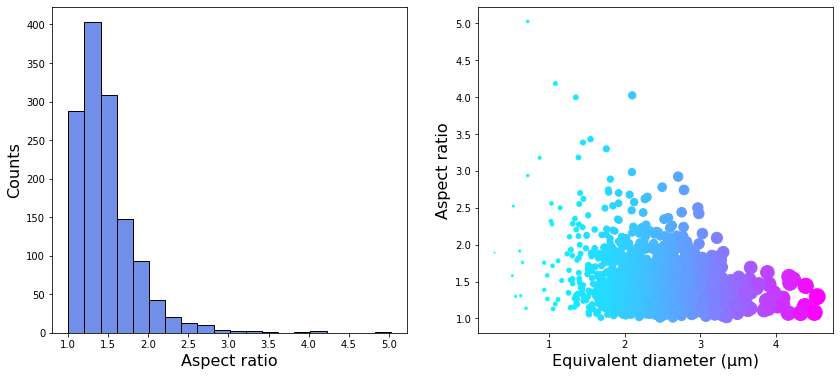

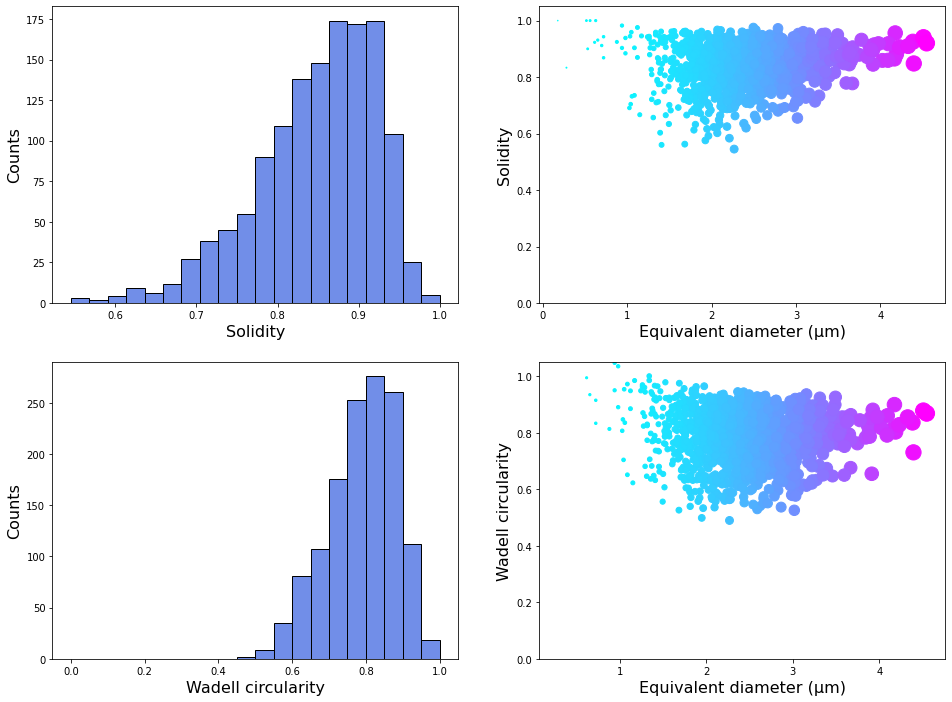

In [9]:
# Calculate further particles properties
markers = np.array(segmented_cle)
#properties_particles = objects_properties(markers, equalised_img)

props = measure.regionprops_table(markers,equalised_img,
                                      properties=["label",
                                      "area", "equivalent_diameter_area",
                                      "perimeter", "centroid", "solidity", "orientation",
                                       "axis_minor_length", "axis_major_length"])
properties = pd.DataFrame(props)

properties["Percentage area"] = properties["area"]/sum(properties["area"])
properties["area_perim"] = 2*properties["area"]/(properties["perimeter"]*(0.5*properties["equivalent_diameter_area"]))
properties["circulary_Wadell"] = (properties["equivalent_diameter_area"]*np.pi) / properties["perimeter"]
# file:///C:/Users/teolo/Downloads/minerals-09-00768.pdf - 
#Wadell, H.A. Sphericity and roundness of rock particles. J. Geol. 1933, 41, 310–331. - 
#Wadell, H.A. Volume, shape and roundness of rock particles. J. Geol. 1932, 40, 443–451.
properties["aspect ratio"] = properties["axis_major_length"]/properties["axis_minor_length"]
properties["equivalent_diameter_um"] = properties["equivalent_diameter_area"]*pixel_lenght/1000

properties = properties.iloc[1: , :]

path_save = directory_res + "\\" + "Region Props - particles_properties.csv"

properties.to_csv(path_save, index=False)

colous = properties["equivalent_diameter_um"]**2/max(properties["equivalent_diameter_um"]**2)
size = colous*250

col_hist = "royalblue"
col_p = plt.cm.cool(colous)

fig_, ax_ = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
sns.histplot(properties["aspect ratio"], bins=20, ax=ax_[0], color=col_hist)
ax_[0].set_xlabel("Aspect ratio", fontsize=16)
ax_[0].set_ylabel("Counts", fontsize=16)
ax_[1].scatter(properties["equivalent_diameter_um"], properties["aspect ratio"], s=size, c=col_p)
ax_[1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
ax_[1].set_ylabel("Aspect ratio", fontsize=16)

path_save = directory_res + "\\" + "Aspect ratio.png"

plt.savefig(path_save, dpi=600)

fig_, ax_ = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))

sns.histplot(properties["circulary_Wadell"], bins=20, ax=ax_[1,0], color=col_hist, binrange=(0,1))
ax_[1,0].set_xlabel("Wadell circularity", fontsize=16)
ax_[1,0].set_ylabel("Counts", fontsize=16)
#ax_[1,0].set_xlim([0,1])
ax_[1,1].scatter(properties["equivalent_diameter_um"], properties["circulary_Wadell"], s=size, c=col_p)
ax_[1,1].set_ylim([0,1.05])
ax_[1,1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
ax_[1,1].set_ylabel("Wadell circularity", fontsize=16)
ax_[1,1] = fig.add_subplot(2,2,2)

sns.histplot(properties["solidity"], bins=20, ax=ax_[0,0], color=col_hist)
ax_[0,0].set_xlabel("Solidity", fontsize=16)
ax_[0,0].set_ylabel("Counts", fontsize=16)
ax_[0,1].scatter(properties["equivalent_diameter_um"], properties["solidity"], s=size, c=col_p)
ax_[0,1].set_ylim([0,1.05])
ax_[0,1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
ax_[0,1].set_ylabel("Solidity", fontsize=16)
ax_[0,1] = fig.add_subplot(2,2,4)

path_save = directory_res + "\\" + "Particles sphericity and regularity.png"

plt.savefig(path_save, dpi=600)